In [1]:
%pip install matplotlib wordcloud

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
   ---------------------------------------- 0.0/7.8 MB ? eta -:--:--
   -- ------------------------------------- 0.5/7.8 MB 2.8 MB/s eta 0:00:03
   ------ --------------------------------- 1.3/7.8 MB 3.0 MB/s eta 0:00:03
   ---------- ----------------------------- 2.1/7.8 MB 3.4 MB/s eta 0:00:02
   ------------- -------------------------- 2.6/7.8 MB 3.3 MB/s eta 0:00:02
   ---------------- ----------------------- 3.1/7.8 MB 3.1 MB/s eta 0:00:02
   -------------------- ------------------- 3.9/7.8 MB 3.1 MB/s eta 0:00:02
   ---------------------- ----------------- 4.5/7.8 MB 3.0 MB/s eta 0:00:02
   ------------------------- -------------- 5.0/7.8 MB 2.9 MB/s eta 0:00:01
   ---------------------------- ----------- 5.5/7.8 MB 2.9 MB/s eta 0:00:01
   -------------------------------- ------- 6.3/7.8 MB 2.9 MB/s eta 0:00:01
   --------------------------------- ----

In [5]:
import sys
print(sys.executable)

c:\Users\yashw\Anime_Recommendation_project2\venv\Scripts\python.exe


In [2]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, BatchNormalization,Input,Embedding,Dot,Dense,Flatten,Reshape,Concatenate,Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,LearningRateScheduler,TensorBoard,EarlyStopping

from wordcloud import WordCloud
%matplotlib inline

######## reading animelist.csv file ########

In [4]:
import os

In [109]:
input_dir = os.path.join("..","artifacts","raw")

In [110]:
rating_df = pd.read_csv(input_dir+"/animelist.csv",low_memory=True,usecols=["user_id","anime_id","rating"])

In [111]:
len(rating_df)

5000000

DATA PROCESSING

In [112]:
n_ratings = rating_df["user_id"].value_counts()
rating_df = rating_df[rating_df["user_id"].isin(n_ratings[n_ratings>=400].index)].copy()


In [113]:
len(rating_df)

3246641

In [114]:
min_rating = min(rating_df["rating"])
max_rating = max(rating_df["rating"])
avg_rating = np.mean(rating_df["rating"])

In [24]:
print(max_rating)

1.0


In [115]:
rating_df["rating"] = rating_df["rating"].apply(lambda x:(x-min_rating) / (max_rating-min_rating)).values.astype(np.float64)


In [25]:
rating_df.duplicated().sum()    

np.int64(0)

In [26]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [116]:
user_id = rating_df["user_id"].unique().tolist()

In [117]:
user2user_encoded = {x : i for i,x in enumerate(user_id)}
user2user_decoded = {i : x for i,x in enumerate(user_id)}
rating_df["user"] = rating_df["user_id"].map(user2user_encoded)

In [118]:
n_users = len(user2user_encoded)
n_users

4203

In [119]:
anime_ids = rating_df["anime_id"].unique().tolist()
anime2anime_encoded = {x : i for i,x in enumerate(anime_ids)}
anime2anime_decoded = {i : x for i,x in enumerate(anime_ids)}
rating_df["anime"] = rating_df["anime_id"].map(anime2anime_encoded)

In [120]:
n_anime = len(anime2anime_encoded)
n_anime

17149

In [121]:
rating_df = rating_df.sample(frac=1,random_state=42).reset_index(drop=True)

In [122]:
rating_df.head()

,user_id,anime_id,rating,user,anime
0,13338,30,0.7,3405,688
1,15967,15583,0.6,4060,1518
2,4967,39586,0.0,1213,4963
3,4055,8039,0.0,997,4097
4,6170,30205,0.0,1552,1690


In [123]:
X = rating_df[["user","anime"]].values
y = rating_df["rating"].values

In [124]:
test_size = 1000
train_indices = rating_df.shape[0] - test_size

In [125]:
X_train, X_test, y_train, y_test = X[:train_indices], X[train_indices:], y[:train_indices], y[train_indices:]

In [126]:
len(X_train), len(X_test), len(y_train), len(y_test)

(3245641, 1000, 3245641, 1000)

In [127]:
type(X_train), type(X_test), type(y_train), type(y_test)

(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [128]:
X_train_array = [X_train[:,0], X_train[:,1]]
X_test_array = [X_test[:,0], X_test[:,1]]

MODEL ARCHITECTURE

In [129]:
def Recommender():
    Embedding_size = 128

    user = Input(name="user",shape=[1])

    user_embedding = Embedding(name="user_embedding",input_dim=n_users,output_dim=Embedding_size)(user)

    anime = Input(name="anime",shape=[1])
    anime_embedding = Embedding(name="anime_embedding",input_dim=n_anime,output_dim=Embedding_size)(anime)

    x = Dot(name="dot_product",normalize=True,axes=2)([user_embedding,anime_embedding])

    x = Flatten()(x)

    x = Dense(1,kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)

    model = Model(inputs = [user,anime], outputs = x)
    model.compile(loss="binary_crossentropy",optimizer=Adam(learning_rate=0.001),metrics=["mae","mse"])

    return model

In [130]:
model = Recommender()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │    537,984 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,195,072 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │          2 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1)         │          4 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,733,062 (10.43 MB)

 Trainable params: 2,733,060 (10.43 MB)

 Non-trainable params: 2 (8.00 B)

In [131]:
start_lr = 0.00001
min_lr = 0.0001
max_lr = 0.00005

batch_size = 10000
ramup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8

# this function is used to calculate the best learning rate for each epoch
def lrfn(epoch):
    if epoch < ramup_epochs:
        return (max_lr - start_lr) / ramup_epochs * epoch + start_lr
    elif epoch < ramup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay ** (epoch - ramup_epochs - sustain_epochs) + min_lr
    


In [132]:
lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=0)
checkpoint_path = './weights.weights.h5'
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min', verbose=1,save_weights_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min', restore_best_weights=True)



In [133]:
my_callbacks = [model_checkpoint, lr_callback,early_stopping]

In [52]:
model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size,
    epochs=20,
    validation_data=(X_test_array, y_test),
    callbacks=my_callbacks,
    verbose=1
)

Epoch 1/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.8005 - mae: 0.3822 - mse: 0.1973
Epoch 1: val_loss improved from inf to 0.71664, saving model to ./weights.weights.h5
325/325 ━━━━━━━━━━━━━━━━━━━━ 37s 106ms/step - loss: 0.8005 - mae: 0.3822 - mse: 0.1973 - val_loss: 0.7166 - val_mae: 0.3645 - val_mse: 0.1673 - learning_rate: 1.0000e-05
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.7971 - mae: 0.3808 - mse: 0.1960
Epoch 2: val_loss did not improve from 0.71664
325/325 ━━━━━━━━━━━━━━━━━━━━ 35s 107ms/step - loss: 0.7971 - mae: 0.3808 - mse: 0.1960 - val_loss: 0.7674 - val_mae: 0.3704 - val_mse: 0.1853 - learning_rate: 1.8000e-05
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.7918 - mae: 0.3789 - mse: 0.1939
Epoch 3: val_loss did not improve from 0.71664
325/325 ━━━━━━━━━━━━━━━━━━━━ 35s 106ms/step - loss: 0.7918 - mae: 0.3789 - mse: 0.1939 - val_loss: 0.7712 - val_mae: 0.3709 - val_mse: 0.1865 - learning_rate: 2.6000e-05
Epoch 4/20
325/325 ━

In [134]:
def extract_weights(name, model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights / np.linalg.norm(weights, axis=1).reshape(-1, 1)
    return weights

In [135]:
anime_weights = extract_weights("anime_embedding", model)
user_weights = extract_weights("user_embedding", model)

READING ANIME.CSV

In [136]:
df = pd.read_csv(input_dir+"/anime.csv",low_memory=True)
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, Magic",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [137]:
df = df.replace("Unknown",np.nan)

In [138]:
df.head(2)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",NaN,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


In [139]:
def getAnimeName(anime_id):
    try:
        name = df[df.anime_id == anime_id].eng_version.values[0]
        if name == "unknown":
            name = df[df.anime_id == anime_id].Name.values[0]
    except:
        print("error")

    return name

In [140]:
df["anime_id"] = df["MAL_ID"]
df["eng_version"] = df["English name"]
df["eng_version"] = df["anime_id"].apply(lambda x: getAnimeName(x))

In [141]:
df.head(2)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,1,Cowboy Bebop
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",NaN,...,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0,5,Cowboy Bebop:The Movie


In [142]:
df.sort_values(by="Score",ascending=False,inplace=True,kind="quicksort",na_position="last")


In [143]:
df.head(5)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
3971,5114,Fullmetal Alchemist: Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen",Fullmetal Alchemist:Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64,"Apr 5, 2009 to Jul 4, 2010",Spring 2009,...,199160.0,70045.0,20210.0,9308.0,3222.0,1536.0,2162.0,16806.0,5114,Fullmetal Alchemist:Brotherhood
15926,40028,Shingeki no Kyojin: The Final Season,9.17,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen",Attack on Titan Final Season,進撃の巨人 The Final Season,TV,16,"Dec 7, 2020 to ?",Winter 2021,...,26016.0,8793.0,2674.0,1336.0,588.0,382.0,514.0,11061.0,40028,Attack on Titan Final Season
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",Steins;Gate,STEINS;GATE,TV,24,"Apr 6, 2011 to Sep 14, 2011",Spring 2011,...,140914.0,57740.0,21375.0,11126.0,5061.0,2292.0,1678.0,5255.0,9253,Steins;Gate
14963,38524,Shingeki no Kyojin Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Shounen, Super Power",Attack on Titan Season 3 Part 2,進撃の巨人 Season3 Part.2,TV,10,"Apr 29, 2019 to Jul 1, 2019",Spring 2019,...,110481.0,33662.0,8365.0,2974.0,1108.0,550.0,385.0,4169.0,38524,Attack on Titan Season 3 Part 2
9913,28977,Gintama°,9.1,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen",Gintama Season 4,銀魂°,TV,51,"Apr 8, 2015 to Mar 30, 2016",Spring 2015,...,21360.0,10215.0,3898.0,2311.0,952.0,648.0,1100.0,4508.0,28977,Gintama Season 4


In [93]:
df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1', 'anime_id',
       'eng_version'],
      dtype='object')

In [144]:
df = df[["anime_id","eng_version","Score","Genres","Episodes","Type","Premiered","Members"]]

In [145]:
df

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen",64,TV,Spring 2009,2248456
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen",16,TV,Winter 2021,733260
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162
14963,38524,Attack on Titan Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Shounen, Super Power",10,TV,Spring 2019,1073626
9913,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen",51,TV,Spring 2015,404121
...,...,...,...,...,...,...,...,...
17557,48481,NaN,NaN,"Adventure, Mystery, Supernatural",NaN,ONA,NaN,354
17558,48483,NaN,NaN,"Comedy, Horror, Supernatural",NaN,TV,NaN,7010
17559,48488,Higurashi:When They Cry – SOTSU,NaN,"Mystery, Dementia, Horror, Psychological, Supernatural, Thriller",NaN,TV,Summer 2021,11309
17560,48491,NaN,NaN,"Adventure, Slice of Life, Comedy",NaN,TV,NaN,1386


In [146]:
def getAnimeFrame(anime,df):
    if isinstance(anime, int):
        return df[df.anime_id == anime]
    elif isinstance(anime, str):
        return df[df.eng_version == anime]
    

In [147]:
getAnimeFrame("Steins;Gate",df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162


ANIME_WITH_SYNOPSIS.CSV

In [148]:
cols = ["MAL_ID","Name","Genres","sypnopsis"]
synopsis_df = pd.read_csv(input_dir+"/anime_with_synopsis.csv",low_memory=True,usecols=cols)

In [149]:
synopsis_df.head(2)

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized several of the planets and moons of the solar system leaving the now uninhabitable surface of planet Earth behind. The Inter Solar System Police attempts to keep peace in the galaxy, aided in part by outlaw bounty hunters, referred to as ""Cowboys."" The ragtag team aboard the spaceship Bebop are two such individuals. Mellow and carefree Spike Spiegel is balanced by his boisterous, pragmatic partner Jet Black as the pair makes a living chasing bounties and collecting rewards. Thrown off course by the addition of new members that they meet in their travels—Ein, a genetically engineered, highly intelligent Welsh Corgi; femme fatale Faye Valentine, an enigmatic trickster with memory loss; and the strange computer whiz kid Edward Wong—the crew embarks on thrilling adventures that unravel each member's dark and mysterious past little by little. Well-balanced with high density action and light-hearted comedy, Cowboy Bebop is a space Western classic and an homage to the smooth and improvised music it is named after."
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of the often unlucky crew of the Bebop. However, this routine is interrupted when Faye, who is chasing a fairly worthless target on Mars, witnesses an oil tanker suddenly explode, causing mass hysteria. As casualties mount due to a strange disease spreading through the smoke from the blast, a whopping three hundred million woolong price is placed on the head of the supposed perpetrator. With lives at stake and a solution to their money problems in sight, the Bebop crew springs into action. Spike, Jet, Faye, and Edward, followed closely by Ein, split up to pursue different leads across Alba City. Through their individual investigations, they discover a cover-up scheme involving a pharmaceutical company, revealing a plot that reaches much further than the ragtag team of bounty hunters could have realized."


In [150]:
def getSypnopsis(anime,df):
    if isinstance(anime, int):
        return synopsis_df[synopsis_df.MAL_ID == anime].sypnopsis.values[0]
    elif isinstance(anime, str):
        return synopsis_df[synopsis_df.Name == anime].sypnopsis.values[0]

In [104]:
getSypnopsis(40028,df)

"Gabi Braun and Falco Grice have been training their entire lives to inherit one of the seven titans under Marley's control and aid their nation in eradicating the Eldians on Paradis. However, just as all seems well for the two cadets, their peace is suddenly shaken by the arrival of Eren Yeager and the remaining members of the Survey Corps. Having finally reached the Yeager family basement and learned about the dark history surrounding the titans, the Survey Corps has at long last found the answer they so desperately fought to uncover. With the truth now in their hands, the group set out for the world beyond the walls. In Shingeki no Kyojin: The Final Season , two utterly different worlds collide as each party pursues its own agenda in the long-awaited conclusion to Paradis' fight for freedom."

CONTENT/ITEM BASED RECOMMENDATION SYSTEM

In [151]:
pd.set_option("max_colwidth", None)

In [154]:
def findSimilarAnime(name,df,synopsis_df,anime_weights,anime2anime_encoded,anime2anime_decoded,n=10,return_dist = False,neg= False):
    try:
        index = getAnimeFrame(name, df).anime_id.values[0]
        encoded_index = anime2anime_encoded.get(index)
        weights = anime_weights
        dists = np.dot(weights,weights[encoded_index])
        sorted_dists = np.argsort(dists)

        n=n+1

        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]
        print(f"anime closest to {name}")

        if return_dist:
            return dists,closest
        
        similarityarr = []
        for colse in closest:
            decoded_id = anime2anime_decoded[colse]
            synopsis = getSypnopsis(decoded_id,synopsis_df)

            anime_frame = getAnimeFrame(decoded_id,df)
            anime_name = anime_frame.eng_version.values[0]
            genre = anime_frame.Genres.values[0]
            similarity = dists[colse]

            similarityarr.append({
                "anime_id": decoded_id,
                "name": anime_name,
                "genre": genre,
                "similarity": similarity,
                "synopsis": synopsis
            })

            Frame = pd.DataFrame(similarityarr).sort_values(by="similarity",ascending=False)
        return Frame[Frame.anime_id != index].drop(["anime_id"],axis=1)
    
    except Exception as e:
        print(f"Error: {e}")

In [155]:
findSimilarAnime("Steins;Gate",df,synopsis_df,anime_weights,anime2anime_encoded,anime2anime_decoded,n=10,return_dist=False,neg=False)

anime closest to Steins;Gate


,name,genre,similarity,synopsis
9,NaN,"Comedy, Parody",0.361148,mated TV commercials for the Nissan Note as part of the Teinenpi Shoujo Heidi sales promotion parody series. The commercials feature unique animation not used in the web commercials.
8,NaN,Kids,0.327595,Kiki and Lala are preparing for Hoshi Matsuri and dreaming of all the fun things they can wish for themselves if they spot a falling star.
7,NaN,Action,0.319701,"In the near future, massive hostile beings called ""Fiarem"" are waging war on Earth. To defend the world from this alien threat, Japan unleashes a special team known as ""Ragna Strikers""—six young women wielding advanced weaponry and the ability to grow to gigantic sizes. Ragnastrike Angels follows Ayano Anemori and her friends as they live their daily lives and battle the violent Fiarem."
6,NaN,"Comedy, Parody, Seinen, Sports, Super Power",0.305508,The second collaboration between Kawasaki Frontale and Tentai Senshi Sunred.
5,Engaged to the Unidentified,"Slice of Life, Comedy, Romance, School",0.302681,"Just an ordinary teenager, Kobeni Yonomori receives quite the surprise on her 16th birthday—a fiancé and a sister-in-law she never even knew she had. As a result of an arrangement that her late grandfather made, Hakuya Mitsumine and his younger sister Mashiro have moved from their countryside home to the Yonomori household in order to deepen their relationship with their new family members. Mikakunin de Shinkoukei follows Kobeni's ""love life"" with Hakuya as she tries her best to adjust to the abrupt changes forced upon her. However, as some extraordinary secrets regarding the siblings come to light, Kobeni will find her life changed forever."
4,NaN,"Demons, Fantasy",0.301994,"The film was adapted from a novel by Okamoto Kidou based on a legend surrounding a sterile patch of land at the foot of Mt. Chausu, an active volcano located in Tochigi Prefecture. Since the Heian period the spot has been known to exude poisonous gas (hydrogen sulfide, sulfur dioxide, arsenic) that has killed animals and people who happened to wander near the area. A legend arose at one time that long ago in China a kitsune transformed itself into a beautiful maiden, seduced the emperor and caused numerous misfortunes to befall the kingdom, then found her way to Japan, transformed herself into a beautiful maiden called Tamamo, and seduced the emperor etc., before finally being unmasked and killed. Upon her death she cursed her killers and transformed herself on this spot into a poisonous stone called Sesshoseki. (Source: Pelleas Anipages)"
3,Beelzebub,"Action, Comedy, Demons, Supernatural, School, Shounen",0.300758,"Ishiyama High is a school populated entirely by delinquents, where nonstop violence and lawlessness are the norm. However, there is one universally acknowledged rule—don't cross first year student Tatsumi Oga, Ishiyama's most vicious fighter. One day, Oga is by a riverbed when he encounters a man floating down the river. After being retrieved by Oga, the man splits down the middle to reveal a baby, which crawls onto Oga's back and immediately forms an attachment to him. Though he doesn't know it yet, this baby is named Kaiser de Emperana Beelzebub IV, or ""Baby Beel"" for short—the son of the Demon Lord! As if finding the future Lord of the Underworld isn't enough, Oga is also confronted by Hildegard, Beel's demon maid. Together they attempt to raise Baby Beel—although surrounded by juvenile delinquents and demonic powers, the two of them may be in for more of a challenge than they can imagine."
2,Balala the Faries:Over the Rainbow,"Comedy, Magic, Shoujo",0.294293,"Not far from the Magical World of Fairy Castle, there is another Magical Kingdom called Colorful Castle. Which is a place full of color, joy and humor, just like a peaceful, carefree paradise... Until one day, at the edge of the Kingdom, There a dark gray island, where the owner of it, The Lord of black curse just woke up from sleep. In order to make his isl

USER BASED RECOMMENDATION

In [156]:
def find_similar_users(item_input,user_weights,user2user_encoded,user2user_decoded,n=10,return_dist=False,neg=False):
    try:
        index = item_input
        encoded_input = user2user_encoded.get(index)

        weights = user_weights
        dists = np.dot(weights, weights[encoded_input])
        sorted_dists = np.argsort(dists)
        n = n + 1
        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]
        print(f"users closest to {index}")
        if return_dist:
            return dists, closest
        similarityarr = []
        for colse in closest:
            
            similarity = dists[colse]
            if isinstance(item_input, int):
                decoded_id = user2user_decoded.get(colse)
                similarityarr.append({
                "user_id": decoded_id,
                "similarity": similarity
            })
        similiar_users = pd.DataFrame(similarityarr).sort_values(by="similarity", ascending=False)
        return similiar_users[similiar_users.user_id != index].drop(["user_id"], axis=1)
    except Exception as e:
        print(f"Error: {e}")

In [159]:
find_similar_users(int(11880),user_weights,user2user_encoded,user2user_decoded,n=10,return_dist=False,neg=False)

users closest to 11880


,similarity
9,0.297730
8,0.294967
7,0.291943
6,0.284809
5,0.277087
4,0.272124
3,0.268315
2,0.256871
1,0.255147
0,0.254783


In [174]:
import matplotlib.pyplot as plt
# import wordcloud
from wordcloud import WordCloud

In [169]:
def showwordcloud(all_genres):
    generes_cloud = WordCloud(width=700, height=400, background_color="white", colormap="viridis").generate(all_genres)
    plt.figure(figsize=(10, 5))
    plt.imshow(generes_cloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [170]:
from collections import defaultdict

In [171]:
def getfavgenre(frame,plot=False):
    frame.dropna(inplace=True)
    all_genres = defaultdict(int)

    genres_list = []
    for genres in frame["Genres"]:
        if isinstance(genres, str):
            for genre in genres.split(","):
                genres_list.append(genre)
                all_genres[genre.strip()] += 1
    if plot:
        showwordcloud(all_genres)
    return genres_list

In [176]:
x = getAnimeFrame(1,df)
x

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",26,TV,Spring 1998,1251960


C:\Users\yashw\AppData\Local\Temp\ipykernel_1948\2491068403.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame.dropna(inplace=True)


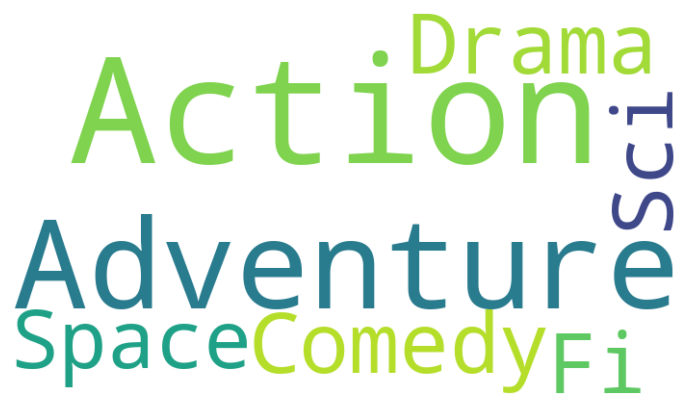

In [177]:
genres_list = getfavgenre(x)
showwordcloud(" ".join(genres_list))

In [180]:
def get_user_preferences(user_id,rating_df,df, verbose=0,plot=False):
    animes_watched_by_user = rating_df[rating_df.user_id == user_id]
    user_rating_percentile = animes_watched_by_user["rating"].quantile(0.75)
    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user["rating"] >= user_rating_percentile]

    top_animes_user = animes_watched_by_user.sort_values(by="rating", ascending=False).anime_id.values

    anime_df_rows = df[df["anime_id"].isin(top_animes_user)]
    anime_df_rows = anime_df_rows[["eng_version","Genres"]]

    if plot:
        getfavgenre(anime_df_rows,plot=True)
    return anime_df_rows




In [183]:
get_user_preferences(11880,rating_df,df,verbose=1,plot=False)

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
741,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
...,...,...
2575,Shootfighter Tekken,"Action, Martial Arts, Shounen"
8064,Samurai Flamenco,"Action, Comedy, Parody, Super Power"
510,Venus Wars,"Action, Sci-Fi, Adventure, Space"
6864,NaN,"Action, Adventure, Fantasy, Shounen"


In [ ]:
def get_user_recommendations(similar_users,user_preferences, rating_df, df,synopsis_df,n=10):
    recommendations = []
    anime_list = []
    for user in similar_users["user_id"].values:

HYBRID RECOMMENDATION

In [ ]:
def hybrid_recommendation(user_id,user_weight=0.5,content_weight=0.5):
    